In [1]:
# !pip install -U scikit-learn

In [2]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

# TP2 - Random Forest Model

El objetivo es crear un primer modelo básico de random forest, sin feature engineering ni hyperparameters tunning, para poder tener un primer resultado local. Luego, realizar un primer submit en kaggle y en base a eso ir mejorando el modelo 

In [3]:
train = pd.read_csv("../datasets/first-rf-model-train.csv")
test = pd.read_csv("../datasets/first-rf-model-test.csv")

train['Month'] = pd.to_datetime(train['Month']).dt.month
test['Month'] = pd.to_datetime(test['Month']).dt.month

In [4]:
test.head(2)

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,Sales_Contract_No,ASP,ASP_(converted),Month,Delivery_Year,...,Last_Modified_By_2,Last_Modified_By_3,Last_Modified_By_4,Last_Modified_By_5,Total_Taxable_Amount_Currency_0,Total_Taxable_Amount_Currency_1,Total_Taxable_Amount_Currency_2,Total_Amount_Currency_0,Total_Amount_Currency_1,Total_Amount_Currency_2
0,1,1,1,1,10689,6436,0.325,0.36761,5,2019,...,0,1,0,0,0,0,1,0,0,1
1,1,1,1,1,10689,6436,0.320,0.36195,5,2019,...,0,1,0,0,0,0,1,0,0,1


In [5]:
target = "target"
features = list(train.columns)
features.remove(target)
len(features)

110

In [6]:
X_train, y_train = train.loc[:,features],train.loc[:,target]
X_test = test

In [7]:
print(X_train.shape)
print(X_test.shape)

(16947, 110)
(2551, 110)


In [8]:
num_of_trees = 25
max_depth = 6
max_features = 10
min_to_split = 15
min_to_leaf = 1

rf_model = RandomForestClassifier(n_estimators=num_of_trees,\
                                     max_depth = max_depth,\
                                     max_features = max_features,\
                                     min_samples_split = min_to_split,\
                                     min_samples_leaf = min_to_leaf,\
                                     random_state=1
                                 )




In [9]:
run = cross_val_score(rf_model,X_train,y_train,cv=1+int(len(X_train)/15),scoring= make_scorer(log_loss))
run_df = pd.Series(run)
run_df.describe()

count    1.130000e+03
mean     1.575741e+00
std      3.221097e+00
min      9.992007e-16
25%      9.992007e-16
50%      9.992007e-16
75%      2.302638e+00
max      1.842073e+01
dtype: float64

In [10]:
round(run_df,2).value_counts()

0.00     788
2.30     164
4.61      72
6.91      42
11.51     20
9.21      17
16.12     13
13.82     10
18.42      2
7.40       1
2.47       1
dtype: int64

<AxesSubplot:ylabel='Density'>

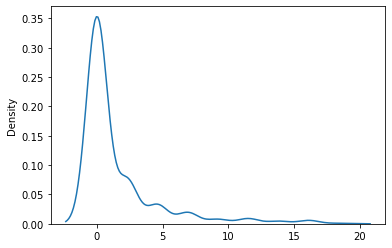

In [11]:
sns.kdeplot(run_df)

In [12]:
rf_model.fit(X_train,y_train)
pred = rf_model.predict_proba(X_test)
pred

array([[0.21777733, 0.78222267],
       [0.19504876, 0.80495124],
       [0.23204041, 0.76795959],
       ...,
       [0.2970197 , 0.7029803 ],
       [0.70846705, 0.29153295],
       [0.85634469, 0.14365531]])

In [13]:
pred_df = pd.DataFrame(X_test["Opportunity_ID"])
pred_df[["Other","Target"]] = pred
pred_df.drop(columns="Other",inplace=True)
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df

,Opportunity_ID,Target
0,10689,0.782223
3,10690,0.723561
8,10691,0.752074
9,10692,0.663150
15,10693,0.849281
...,...,...
2545,12364,0.759630
2547,12365,0.713170
2548,12366,0.702980
2549,12367,0.291533


In [14]:
# Exportamos el resultado para hacer un submit

pred_df.to_csv("../submits/rf_model1.csv", index=False)


In [15]:
from log.Logger import Logger

model_name = "RandomForest"
score = 1.5
kaggle_score = 0.30216
notas = "intento1 - set filtrado y features encodeadas"
dataset_name = "first-rf-model-train.csv"
hyperparm = {"n_estimators": num_of_trees,
              "max_depth" : max_depth,
              "max_features" : max_features,
              "min_samples_split" : min_to_split,
              "min_samples_leaf" : min_to_leaf,
              "random_state" : 1
            }

Logger.log_model(model_name,score,kaggle_score,notas,dataset_name,hyperparm)

Model logged successfully


In [16]:
to_plot = pd.DataFrame(zip(X_train,rf_model.feature_importances_),columns=["Column","Importance"])\
            .sort_values("Importance", ascending= False)
            
print("Suma de importancias: ", to_plot["Importance"].sum())

to_plot= to_plot.nlargest(15,"Importance")
to_plot.head()

Suma de importancias:  1.0


,Column,Importance
5,Sales_Contract_No,0.481355
82,Bureaucratic_Code_2,0.084305
10,TRF,0.053711
11,Total_Amount,0.049053
76,Opportunity_Type_1,0.038405


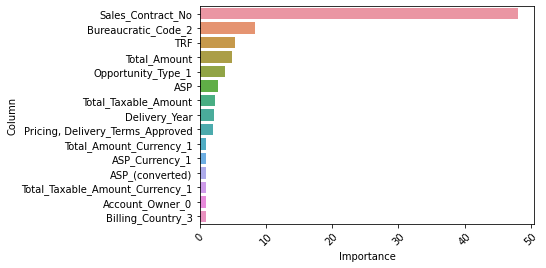

In [17]:
sns.barplot(x=(to_plot["Importance"]*100),y=to_plot["Column"],orient="h")
plt.xticks(rotation=45)
plt.show()